In [1]:
import  numpy  as np 
import  pandas as pd 
import  os
import  tqdm

%matplotlib inline
import  matplotlib.pyplot as plt
import  seaborn as sns 

# local hunter packages
import  hunter.core.visual.plots as viz
import  hunter.mlops.experiments.experiment as exp

In [2]:
# huggingface
import transformers
from tokenizers import (
    CharBPETokenizer,           # The original BPE
    ByteLevelBPETokenizer,      # The byte level version of the BPE
    SentencePieceBPETokenizer,  # A BPE implementation compatible with the one used by SentencePiece
    BertWordPieceTokenizer      # The famous Bert tokenizer, using WordPiece
)
vocab_src = "bert-base-uncased-vocab.txt"

# Setup Experiment

In [3]:
user_dir       = os.getenv("HOME")
data_root_dir  = os.path.join(user_dir,      "dev-platform/data")
vocab_root_dir = os.path.join(data_root_dir, "nlp/vocab")
data_proj_dir  = os.path.join(data_root_dir, "nlp/sandbox/")
vocab_src      = "bert-base-uncased-vocab.txt"

In [4]:
experiment = exp.Experiment(project_name='bert-tokenizers', tags={'category':'nlp'})
experiment.add_data_uri(os.path.join(data_proj_dir, 'anna.txt'))
experiment.add_vocab_uri(os.path.join(vocab_root_dir, vocab_src))
experiment.list_project_dir()
#experiment._project_dir; experiment.datasrc_uri; experiment.vocabsrc_uri

['man', 'releases', 'tests', 'exports', 'env', 'scripts', 'external', 'data', 'apps']


# Load Data Corpus

In [5]:
# load text file and extract sentences
import spacy
nlp = spacy.load("en_core_web_sm")

get_sentences = lambda doc: [sent.string.strip() for sent in doc.sents]
with open(experiment.datasrc_uri, 'r') as f:
    data = f.read()[:10000]
    doc  = nlp(data)    
    sentences = get_sentences(doc)

# (Tokenizer) Vocabulary Distribution
- Look at the Tokenizers and Vocabuulary source used into each tokenizer library

In [6]:
tokenizer_tk     = BertWordPieceTokenizer(experiment.vocabsrc_uri)
vocab_size_tk    = tokenizer_tk.get_vocab_size()
tokenizer_tsfrm  = transformers.BertTokenizer(experiment.vocabsrc_uri)
vocab_size_tsfrm = tokenizer_tsfrm.vocab_size
vocab_size_tk, vocab_size_tsfrm

(30522, 30522)

In [7]:
# based off of dictionary we loaded into the tokenizer  
from collections import OrderedDict
with open(experiment.vocabsrc_uri, 'r') as f:
    data_lines = (map(lambda s: s.strip('\n'), f.readlines()))
    vocab_dict = OrderedDict({v:k for k,v in enumerate(data_lines, 0)})
    
# extract vocabulary from both types of tokenizers
def extract_token_lengths(tokenizer_vocab:OrderedDict):
    token_lens         = [len(token) for token, token_id in tokenizer_vocab.items()]
    token_subword_lens = [(len(token) - 2) for token, token_id in tokenizer_vocab.items()
                           if len(token) >=2 and token[0:2] == '##']
    return token_lens, token_subword_lens

token_lens_tk, tokens_subword_lens_tk       = extract_token_lengths(vocab_dict)
token_lens_tsfrm, tokens_subword_lens_tsfrm = extract_token_lengths(tokenizer_tsfrm.vocab)

Max Token Length: 18, 18
% Tokens starting with '##': 19.1%


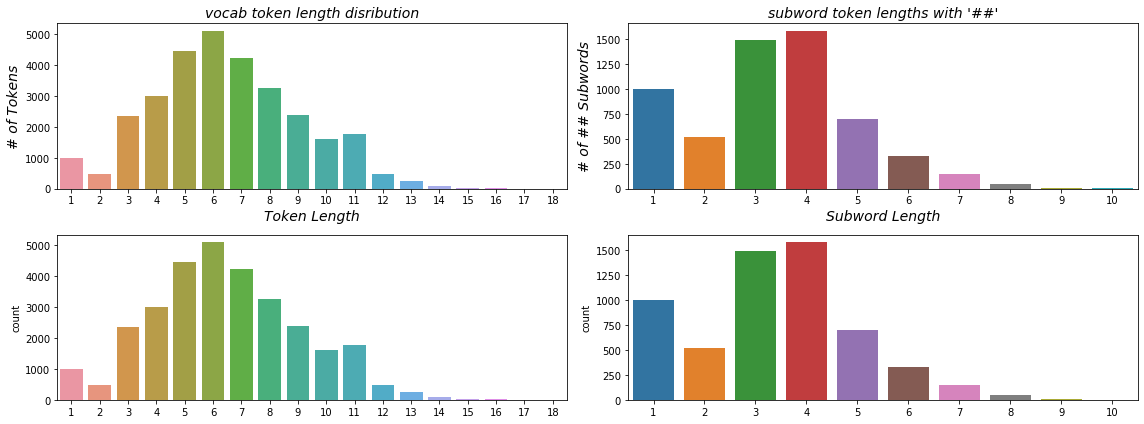

In [8]:
fig, ax  = plt.subplots(2,2, figsize=(16,6))
ax1, ax2, ax3, ax4 = ax.flatten()
sns.countplot(token_lens_tk, ax=ax1)
sns.countplot(token_lens_tsfrm, ax=ax3)
params = {'title': 'vocab token length disribution', 'xaxis-label': 'Token Length', 'yaxis-label': '# of Tokens'}
viz.set_axis_opts(ax1, **params)
print(f"Max Token Length: {max(token_lens_tk)}, {max(token_lens_tsfrm)}")

sns.countplot(tokens_subword_lens_tk, ax=ax2)
sns.countplot(tokens_subword_lens_tsfrm, ax=ax4)
params = {'title':"subword token lengths with '##'",'xaxis-label':'Subword Length','yaxis-label':'# of ## Subwords'}
viz.set_axis_opts(ax2, **params)
print(f"% Tokens starting with '##': {round( float(len(tokens_subword_lens_tk)) / vocab_size_tk * 100.0, 1)}%")
plt.tight_layout()

# Encoding 
- Single text string
- Batch of records

In [9]:
sample_text = sentences[2]
df = pd.DataFrame(sentences, columns=['text'])

# Transformer Library

In [10]:
# From Transformer Library
print('Original:\t', sample_text)
print('Tokenized:\t', tokenizer_tsfrm.tokenize(sample_text, add_special_tokens=True))
print('Token IDs:\t', tokenizer_tsfrm.convert_tokens_to_ids(tokenizer_tsfrm.tokenize(sample_text, add_special_tokens=True)))

Original:	 The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
Tokenized:	 ['the', 'wife', 'had', 'discovered', 'that', 'the', 'husband', 'was', 'carrying', 'on', 'an', 'int', '##rigue', 'with', 'a', 'french', 'girl', ',', 'who', 'had', 'been', 'a', 'govern', '##ess', 'in', 'their', 'family', ',', 'and', 'she', 'had', 'announced', 'to', 'her', 'husband', 'that', 'she', 'could', 'not', 'go', 'on', 'living', 'in', 'the', 'same', 'house', 'with', 'him', '.']
Token IDs:	 [1996, 2564, 2018, 3603, 2008, 1996, 3129, 2001, 4755, 2006, 2019, 20014, 27611, 2007, 1037, 2413, 2611, 1010, 2040, 2018, 2042, 1037, 21208, 7971, 1999, 2037, 2155, 1010, 1998, 2016, 2018, 2623, 2000, 2014, 3129, 2008, 2016, 2071, 2025, 2175, 2006, 2542, 1999, 1996, 2168, 2160, 2007, 2032, 1012]


# Tokenizer Library

In [11]:
# From Hugging Face Tokenizer Library
print('Original:', sample_text)
print(list(tokenizer_tk.encode(sample_text).tokens))
print(list(tokenizer_tk.encode(sample_text).ids))

Original: The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
['[CLS]', 'the', 'wife', 'had', 'discovered', 'that', 'the', 'husband', 'was', 'carrying', 'on', 'an', 'int', '##rigue', 'with', 'a', 'french', 'girl', ',', 'who', 'had', 'been', 'a', 'govern', '##ess', 'in', 'their', 'family', ',', 'and', 'she', 'had', 'announced', 'to', 'her', 'husband', 'that', 'she', 'could', 'not', 'go', 'on', 'living', 'in', 'the', 'same', 'house', 'with', 'him', '.', '[SEP]']
[101, 1996, 2564, 2018, 3603, 2008, 1996, 3129, 2001, 4755, 2006, 2019, 20014, 27611, 2007, 1037, 2413, 2611, 1010, 2040, 2018, 2042, 1037, 21208, 7971, 1999, 2037, 2155, 1010, 1998, 2016, 2018, 2623, 2000, 2014, 3129, 2008, 2016, 2071, 2025, 2175, 2006, 2542, 1999, 1996, 2168, 2160, 2007, 2032, 1012, 102]


In [12]:
# Encode a single sentence one at at a time
encodings = df.text.apply(lambda s: tokenizer_tk.encode(s)) 
max_len   = max([len(encoded) for encoded in encodings])
print(encodings[2].original_str)
print(encodings[2].ids) # [CLS]=101, [SEP]=102
print(f"maximum sequence length of corpus: {max_len}")

The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
[101, 1996, 2564, 2018, 3603, 2008, 1996, 3129, 2001, 4755, 2006, 2019, 20014, 27611, 2007, 1037, 2413, 2611, 1010, 2040, 2018, 2042, 1037, 21208, 7971, 1999, 2037, 2155, 1010, 1998, 2016, 2018, 2623, 2000, 2014, 3129, 2008, 2016, 2071, 2025, 2175, 2006, 2542, 1999, 1996, 2168, 2160, 2007, 2032, 1012, 102]
maximum sequence length of corpus: 66


In [13]:
# Encode via batch
encodings    = tokenizer_tk.encode_batch(list(df.text.values))
max_len      = max([len(encoded) for encoded in encodings])
encoding_ids = list(map(lambda x: x.ids,encodings))
print(encodings[2].original_str)
print(encodings[2].ids) # [CLS]=101, [SEP]=102
print(f"maximum sequence length of corpus: {max_len}")

The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
[101, 1996, 2564, 2018, 3603, 2008, 1996, 3129, 2001, 4755, 2006, 2019, 20014, 27611, 2007, 1037, 2413, 2611, 1010, 2040, 2018, 2042, 1037, 21208, 7971, 1999, 2037, 2155, 1010, 1998, 2016, 2018, 2623, 2000, 2014, 3129, 2008, 2016, 2071, 2025, 2175, 2006, 2542, 1999, 1996, 2168, 2160, 2007, 2032, 1012, 102]
maximum sequence length of corpus: 66
